In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
image_size=[224,224] # vgg16 is made with 224 x 224,so our input must be of same size

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls '/content/drive'

MyDrive


In [6]:
train_path='/content/drive/MyDrive/archive (1)/train'
test_path='/content/drive/MyDrive/archive (1)/test'

In [7]:
from PIL import Image 
import os 
from IPython.display import display
from IPython.display import Image as _Imgdis
# creating a object  

folder = train_path+'/benign'

onlybenignfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} images".format(len(onlybenignfiles)))

Working with 1440 images


1507.jpg


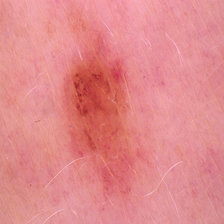

1461.jpg


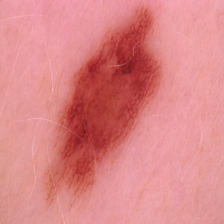

In [8]:
for i in range(2):
    print(onlybenignfiles[i])
    display(_Imgdis(filename=folder + "/" + onlybenignfiles[i], width=240, height=240))

In [9]:
vgg=VGG16(input_shape=image_size + [3], weights='imagenet', include_top=False) # 3channels for rgb, 1 for black&weight
# include_top is for whether last layer is needed or not, If False, not needed

58900480/58889256 [==============================] - 0s 0us/step


In [10]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [11]:
for layer in vgg.layers:
  layer.trainable=False # do not train vgg16 layers

In [12]:
# how many categories are present in out train, we have benign and malignant
folders=glob('/content/drive/MyDrive/archive (1)/train/*')
print(len(folders))

2


In [13]:
x=Flatten()(vgg.output) #Flatten the outputs of the previous layer
prediction = Dense(len(folders), activation='softmax')(x) # we are appending last layer with the current classes after the flattened layer x
model = Model(inputs=vgg.input, outputs=prediction)
model.summary() # 2 outputs in the end

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
from keras import optimizers
adam=optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
# Image Augmentation
train_data_gen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [16]:
test_data_gen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [17]:
train_set=train_data_gen.flow_from_directory(train_path,
                                             target_size=(224,224),
                                     batch_size=32, class_mode='categorical'        )

Found 2637 images belonging to 2 classes.


In [19]:
test_set=test_data_gen.flow_from_directory(test_path,
                                             target_size=(224,224),
                                     batch_size=32, class_mode='categorical' )

Found 660 images belonging to 2 classes.


In [26]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=5,
  validation_steps=len(train_set),
  callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
5/5 - 423s - loss: 1.8808 - accuracy: 0.8062 - val_loss: 2.3670 - val_accuracy: 0.7712

Epoch 00001: val_loss improved from inf to 2.36696, saving model to mymodel.h5
Epoch 2/10
5/5 - 86s - loss: 3.0168 - accuracy: 0.7937
Epoch 3/10
5/5 - 85s - loss: 2.6108 - accuracy: 0.7812
Epoch 4/10
5/5 - 87s - loss: 1.6649 - accuracy: 0.7937
Epoch 5/10
5/5 - 84s - loss: 1.7312 - accuracy: 0.7688
Epoch 6/10
5/5 - 83s - loss: 1.5784 - accuracy: 0.8125
Epoch 7/10
5/5 - 85s - loss: 1.2732 - accuracy: 0.8438
Epoch 8/10
5/5 - 84s - loss: 1.5132 - accuracy: 0.8250
Epoch 9/10
5/5 - 85s - loss: 2.0229 - accuracy: 0.7750
Epoch 10/10
5/5 - 84s - loss: 1.9510 - accuracy: 0.8125
Training completed in time:  0:24:35.195845


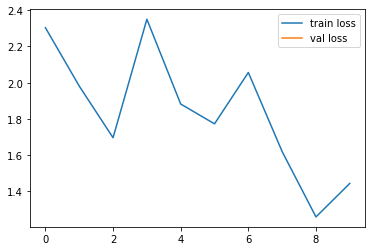

In [23]:
# Plot training & validation loss values
# loss
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')


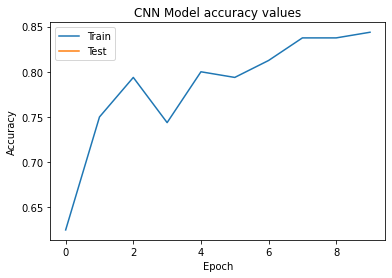

In [24]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()